In [11]:
!py -m pip install langgraph-checkpoint-sqlite

# !py -m pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.9
    Uninstalling langgraph-checkpoint-2.0.9:
      Successfully uninstalled langgraph-checkpoint-2.0.9



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!py -m pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.0.0
aiohttp                                  3.9.5
aiosignal                                1.3.1
altair                                   5.3.0
annotated-types                          0.6.0
anyio                                    3.5.0
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
asttokens                                2.0.5
astunparse                               1.6.3
async-timeout                            4.0.3
asyncio                                  3.4.3
attrs                                    21.4.0
Babel                                    2.9.1
backcall                                 0.2.0
backoff                                  2.2.1
bcrypt                                   4.1.3
beautifulsoup4                           

opentelemetry-sdk                        1.24.0
opentelemetry-semantic-conventions       0.45b0
opentelemetry-util-http                  0.45b0
opt-einsum                               3.3.0
ordered-set                              4.1.0
orjson                                   3.10.1
overrides                                7.7.0
packaging                                23.2
pandas                                   2.2.3
pandocfilters                            1.5.0
parso                                    0.8.3
pathspec                                 0.9.0
patsy                                    0.5.6
pdf2image                                1.17.0
pickleshare                              0.7.5
pillow                                   10.4.0
pip                                      24.3.1
pipreqs                                  0.5.0
platformdirs                             4.3.6
playsound                                1.3.0
plotly                                   5.19.0
plotni

In [2]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
import pandas as pd
import os
import shutil
import numpy as np
from uuid import uuid4
from langchain_community.document_loaders import PyPDFLoader, UnstructuredWordDocumentLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.docstore.document import Document
from typing import List, Tuple
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage, HumanMessage
import re
from typing import Annotated, TypedDict
import operator
from langchain_core.documents import Document
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

In [3]:
OPENAI_DEPLOYMENT_ENDPOINT = "https://advancedanalyticsopenaikey.openai.azure.com/"
OPENAI_DEPLOYMENT_ENDPOINT_embed = "https://pkl-aa-dev-aiservices.openai.azure.com/" 
OPENAI_API_KEY = "FqFd4DBx1W97MSVjcZvdQsmQlhI80hXjl48iWYmZ4W3NutUlWvf0JQQJ99BDACYeBjFXJ3w3AAABACOGl3xo" 
OPENAI_API_VERSION = "2024-12-01-preview"
OPENAI_API_KEY_EMBEDDINGS = "AXEC3y1jC9ZNGCBB12NZwrpBSzScq1esexgvCXiqw7PaHE04vSMbJQQJ99BDACYeBjFXJ3w3AAABACOG4CMN" 
OPENAI_DEPLOYMENT_NAME = "gpt-4o"
OPENAI_MODEL_NAME="gpt-4o"
embedding_api_version = "2024-02-01"

# OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
# CHROMA_PATH = "c:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\SERFF\\vector_db\\testing_db"
DB_PATH  = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\vector_db"
DATA_FOLDER = "C:\\Users\\SujaySunilNagvekar\\VM\\GEN AI\\KM\\Documents"

### Cohere API key 
# cohere_API_key = "wHyiTViP32Y3Q8Qwhjmd4QGNCkYNpxqtsemtSri3"
# co = cohere.Client(cohere_API_key)

In [4]:

llm = AzureChatOpenAI(
                        temperature=0,
                        deployment_name=OPENAI_DEPLOYMENT_NAME,
                        model_name=OPENAI_MODEL_NAME,
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT,
                        openai_api_version=OPENAI_API_VERSION,
                        openai_api_key=OPENAI_API_KEY            
                    )

embeddings = AzureOpenAIEmbeddings(
                        deployment="text-embedding-3-small",
                        model="text-embedding-3-small",
                        azure_endpoint=OPENAI_DEPLOYMENT_ENDPOINT_embed,
                        openai_api_version=embedding_api_version,
                        openai_api_key=OPENAI_API_KEY_EMBEDDINGS)


# Graphstate

In [5]:
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field
from langchain_core.documents import Document

class GraphState(TypedDict, total=False):
    user_query: str
    reformulated_query: str
    reformulation_required: bool
    subqueries: list  # includes SQL and RAG subqueries
    rag_outputs: Annotated[list[Document], operator.add]  # ✅ RAG chunks accumulated
    sql_outputs: Annotated[list[str], operator.add]       # ✅ SQL results accumulated
    final_response: str
    memory: list


### Query Analyser

In [909]:
from pydantic import BaseModel, Field


In [ ]:
from langchain_core.tools import tool
from functools import partial

def make_retrieve_memory_node(store, user_id: str):
    def retrieve_memory_node(state: MessagesState):
        print("📚 [Node] Retrieving memory...")

        # Extract user query from the last HumanMessage
        user_query = next(
            (m.content for m in reversed(state["messages"]) if m.type == "human"),
            ""
        )
        print("📚 Retrieving recent memory for user_id:", user_id)
        namespace = (user_id, "memories")
        recent_memories = store.search(namespace, query=user_query, limit=3)
        print(f"🧠 Retrieved {len(recent_memories)} past memories")
        memory_str = "\n\n".join([
                f"- User: {m.value.get('user_query', '')}\n"
                # f"- Final Response: {m.value.get('final_response', '')}"
                for m in recent_memories
            ]) or "(no relevant memory found)"

        message = (
            "🧠 The following is past memory retrieved from previous interactions. "
            "Use it for context only. Always validate current schema, metrics, and logic "
            "as memory may be stale or incomplete.\n\n"
            f"{memory_str}"
        )
   
        # ✅ Store memory in the state for later nodes (like llm_call)
        state["retrieved_memory"] = message

        # ✅ Optionally append memory message to conversation (optional, not needed by llm_call)
        state["messages"].append(SystemMessage(content=message))

        return state  # 👈 Return full state object, not a new dict


    return retrieve_memory_node




In [1070]:
# from langchain_core.tools import tool

# @tool
# def query_reformulator_tool(user_query: str, memory: str) -> str:
#     """
#     Reformulates the user query using memory/context if necessary.
#     Returns a clarified or reformulated query for the agent to proceed with.
#     """
#     print("🧐 Checking query clarity and possibly reformulating...")

#     # Step 1: Structured decision
#     decision_result = chain_query_clarity_check.invoke({
#         "user_query": user_query,
#         "memory": memory,
#     })

#     print("🔍 Reformulation required:", decision_result.requires_reformulation)

#     # Step 2: Structured reformulation if required
#     if decision_result.requires_reformulation:
#         reformulated_result = chain_reformulation.invoke({
#             "user_query": user_query,
#             "memory": memory,
#         })

#         print("✍️ Reformulated Query:", reformulated_result.reformulated_query)
#         return reformulated_result.reformulated_query

#     return user_query


In [1071]:
reformulation_prompt = """
Given the chat history and the latest user question, which might reference context in the chat history, 
reformulate the question into a standalone question that can be understood without the chat history. 
If the question is related to the most recent queries or requires context from the chat history to be understood, 
include that context in the reformulated question. Do NOT answer the question; just provide the reformulated version.
"""

reformulation_decision_prompt = """
You are an assistant that determines whether the user query requires reformulation using prior chat history.
Answer True only if the query is ambiguous, vague, or clearly follows from prior conversation.
Answer False if the query is already self-contained and understandable on its own.

Respond using the function format below.
"""

class ReformulationDecision(BaseModel):
    """
    Determines whether the query should be reformulated based on chat history context.
    """
    requires_reformulation: bool = Field(
        description="True if the user query depends on chat history or is ambiguous. False if it is already clear and self-contained."
    )

class ReformulatedQuery(BaseModel):
    """
    Reformulated user query that is self-contained and does not require chat history for understanding.
    """
    reformulated_query: str = Field(
        description="A rewritten version of the user's question that includes necessary context from prior conversation."
    )
contextualize_prompt = ChatPromptTemplate.from_messages([ 
    ("system", reformulation_prompt.strip()),
    ("human", 
     "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nRewritten Question:")
        ])

clarity_prompt = ChatPromptTemplate.from_messages([
    ("system", reformulation_decision_prompt.strip()),
    ("human",
     "Chat History:\n{memory}\n\nCurrent User Question:\n{user_query}\n\nDoes this query require reformulation?")
])


structured_llm_reformulation_resolution = llm.with_structured_output(
    schema=ReformulatedQuery,
    method="function_calling"
)

structured_clarity_resolution = llm.with_structured_output(
    schema=ReformulationDecision,
    method="function_calling"
)

chain_reformulation = contextualize_prompt | structured_llm_reformulation_resolution
chain_query_clarity_check = clarity_prompt | structured_clarity_resolution

In [1072]:
def query_reformulator_node(state: MessagesState):
    print("🔁 [Node] Reformulating query using structured LLM...")

    user_msg = next((m for m in reversed(state["messages"]) if m.type == "human"), None)
    user_query = user_msg.content if user_msg else ""
    memory = next(
            (m.content for m in reversed(state["messages"])
            if m.type == "system" and "past memory retrieved" in m.content),
            ""
        )
    
    clarity_response: ReformulationDecision = chain_query_clarity_check.invoke({
            "user_query": user_query,
            "memory": memory
        })
    if clarity_response.requires_reformulation:
        print("🧠 Not self-contained → Reformulating based on memory")
        
        output: ReformulatedQuery = chain_reformulation.invoke({
            "user_query": user_query,
            "memory": memory
        })
    
        print("✍️ Reformulated Query:", output.reformulated_query)

    # Step 2: Replace the latest HumanMessage with the reformulated query
        if user_msg:
            user_msg.content = output.reformulated_query
    else:
        print("✅ Query is already self-contained. No reformulation needed.")
        
    return state


In [1073]:
from pydantic import BaseModel, Field
from typing import List, Literal

class SubQuery(BaseModel):
    query: str = Field(
        description="An atomic sub-question derived from the user's original query."
    )
    intent: Literal["sql", "rag", "other"] = Field(
        description="The type of execution this sub-query requires: 'sql' for structured database queries, 'rag' for document retrieval and summarization, or 'other' for fallback/general."
    )

class SubQueryList(BaseModel):
    subqueries: List[SubQuery] = Field(
        description="List of parsed and intent-classified sub-queries from the original user question."
    )


In [1074]:
from langchain.prompts import ChatPromptTemplate

analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """You are a query analysis agent. Your job is to:
1. Understand the user query.
2. Break it into smaller subqueries if it contains multiple parts.
3. Classify each subquery into one of: 
   - 'sql' (structured data, e.g., counts, trends, metrics),
   - 'rag' (policy/guidelines/instructions from unstructured documents),
   - 'other' (if it doesn't fit the above).
Output a list of subqueries as structured JSON.
"""),
    ("human", "User Query:\n{user_query}\n\nReturn the parsed and classified subqueries:")
])


In [1075]:
structured_llm_query_analysis = llm.with_structured_output(
    schema=SubQueryList,
    method="function_calling"  # Optional but good for structured output
)

query_analysis_chain = analyzer_prompt | structured_llm_query_analysis


In [1076]:
from langchain_core.tools import tool

@tool
def query_analyzer_tool(user_query: str) -> str:
    """
    Analyzes a user query to extract subqueries and their intents.
    Returns a formatted string summary of the extracted subqueries.
    """
    print("🔍 Running Query Analyzer Tool")

    structured = query_analysis_chain.invoke({"user_query": user_query})

    print("🧠 Subqueries extracted:")
    for sq in structured.subqueries:
        print(f"- [{sq.intent.upper()}] {sq.query}")

    if not structured.subqueries:
        return "No subqueries identified."

    # Return a readable summary string (ReAct tools expect string outputs)
    summary = "\n".join([f"[{sq.intent}] {sq.query}" for sq in structured.subqueries])
    return summary


## RAG worker state

In [1077]:
from typing import Annotated, TypedDict
import operator
from langchain_core.documents import Document

class RAGWorkerState(TypedDict):
    query: str
    rag_outputs: List[Document] 



In [1078]:
# Set your vector DB path

import pickle
from langchain_community.vectorstores import FAISS
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

DB_PATH = r"C:\Users\SujaySunilNagvekar\VM\GEN AI\KM\vm-GenAI_BI\vector_db"
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
# Load FAISS vector store (child chunks)
vectorstore = FAISS.load_local(
    DB_PATH,
    embeddings=embeddings,  # Your OpenAI or other embedding model
    allow_dangerous_deserialization=True
)

# Load parent docstore
with open(os.path.join(DB_PATH, "parent_docstore.pkl"), "rb") as f:
    parent_data = pickle.load(f)

# ✅ Initialize LangChain-compatible InMemoryStore
docstore = InMemoryStore()
docstore.mset(list(parent_data.items()))  # pass as list of (id, doc) tuples

# Initialize retriever
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [1079]:
# from langchain_core.documents import Document

# def rag_worker(state: RAGWorkerState):
#     query = state["query"]
#     print(f"📥 RAG Worker received query: {query}")

#     # Step 1: Retrieve top-k child chunks based on similarity
#     child_chunks = vectorstore.similarity_search(query, k=5)

#     # Step 2: Extract unique parent document IDs from child chunk metadata
#     parent_ids = list({chunk.metadata.get("doc_id") for chunk in child_chunks if "doc_id" in chunk.metadata})

#     # Step 3: Fetch parent documents from the docstore using mget
#     parent_docs_map = docstore.mget(parent_ids)  # returns list in same order, may include None
#     parent_docs = [doc for doc in parent_docs_map if doc is not None]

#     if not parent_docs:
#         print("⚠️ No parent documents found. Falling back to child chunks.")
#         return {"rag_outputs": child_chunks[:3]}

#     # Step 4: Return top N parent documents
#     return {"rag_outputs": parent_docs[:3]}



In [1080]:
retriever.invoke("explain paths for Non-Injury Claims")

[Document(metadata={'filename': 'FNOL Intake SW_Final_1.30.18.docx'}, page_content='No coverage questions The insured reported the loss No subrogation potential Auto Investigation Unit Assignment based on the following criteria: Doesn’t meet Fast Track criteria The claim owner will assign the BI exposure to the BI unit, unless it meets Complex Injury criteria Injury Claims Assignment has 4 potential paths: Early Resolution, Auto Investigation, Complex Bodily Injury (BI), Med Pay/PIP Early Resolution Team Assignment based on 2 main categories: Accident Type and Liability Accident Types Included Injury Types Included Accidents where liability is clearly adverse to the insured. Examples of accident types where the insured is the majority at fault are as follows: Insured ran a stop sign or traveled through a red light (failure to yield the right of way) Insured hit a stationary vehicle Insured pulled into the roadway from a driveway Insured struck another vehicle while changing lanes Insur

In [1081]:
from langchain_core.tools import tool
from functools import partial
from typing import List

def make_rag_worker_tool(retriever):
    @tool
    def rag_worker_tool(query: str) -> str:
        """
        Retrieves relevant documents for the given query using RAG.
        Returns top 3 results as a combined string summary.
        """
        print(f"📥 RAG Worker received query: {query}")

        # Retrieve top-k child chunks and trace back to parent docs
        results = retriever.invoke(query)

        if not results:
            return "No relevant documents found."

        # Return a summarized version of top 3 parent documents
        top_results = results[:3]
        combined_text = "\n\n---\n\n".join([doc.page_content for doc in top_results])

        return combined_text

    return rag_worker_tool


In [1042]:
# from langchain_core.tools import tool
# from functools import partial
# from typing import List

# def make_rag_worker_tool(retriever):
#     @tool
#     def rag_worker_tool(query: str) -> str:
#         """
#         Retrieves relevant documents for the given query using RAG.
#         Returns top 3 results as a combined string summary.
#         """
#         print(f"📥 RAG Worker received query: {query}")

#         # Step 1: Retrieve top-k child chunks based on similarity
#         child_chunks = vectorstore.similarity_search(query, k=5)

#         # Step 2: Extract unique parent document IDs from child chunk metadata
#         parent_ids = list({chunk.metadata.get("doc_id") for chunk in child_chunks if "doc_id" in chunk.metadata})

#         # Step 3: Fetch parent documents from the docstore using mget
#         parent_docs_map = docstore.mget(parent_ids)  # returns list in same order, may include None
#         parent_docs = [doc for doc in parent_docs_map if doc is not None]

#         if not parent_docs:
#             print("⚠️ No parent documents found. Falling back to child chunks.")
#             return {"rag_outputs": child_chunks[:3]}

#         # Step 4: Return top N parent documents
#     return {"rag_outputs": parent_docs[:3]}

In [1043]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.documents import Document

@tool
def synthesizer_tool(user_query: str, sql_outputs: List[str] = [], rag_outputs: List[str] = []) -> str:
    """
    Synthesizes a final answer based on SQL results and RAG (document) context.
    Returns a clear, accurate natural language response.
    """
    print("🧠 Synthesizing final output...")

    rag_context = "\n\n".join(rag_outputs) if rag_outputs else "None"
    sql_context = "\n\n".join(sql_outputs) if sql_outputs else "None"

    prompt = [
        SystemMessage(content="""You are an assistant for insurance knowledge management. Use the provided SQL results and/or document context—which may include claims data, policy documents, and regulatory guidelines—to answer the user's question accurately and clearly. Do not hallucinate or include information that is not in the context."""),

        HumanMessage(content=f"""SQL Results:
{sql_context}

RAG Context:
{rag_context}

Question: {user_query}

Answer in a clear, helpful, and factual way using the context above.
""")
    ]

    response = llm.invoke(prompt)
    return response.content



## SQL worker

In [891]:
from typing import TypedDict, Annotated, List
import operator

class SQLWorkerState(TypedDict):
    query: str
    sql_outputs: list[str]


In [892]:
# from langgraph.constants import Send

# def assign_workers(state: GraphState):
#     """Route to either RAG or SQL worker based on subquery intent"""
#     return [
#         Send("rag_worker", {"query": sq.query}) if sq.intent == "rag"
#         else Send("sql_worker", {"query": sq.query})
#         for sq in state["subqueries"]
#     ]



## Get Schema and Definitions

In [893]:
from langchain_core.tools import tool
import json

@tool
def get_schema_tool(dummy: str = "") -> str:
    """
    Loads the full table schema and metric definitions for SQL generation and reasoning.
    Returns a string summary combining both files.
    """
    print("📄 Loading schema and metric definitions...")

    try:
        with open("new_schema.json", "r") as f:
            table_schema = json.load(f)

        with open("vocab_dictionary.json", "r") as f:
            metric_definitions = json.load(f)

    except FileNotFoundError as e:
        return f"Error loading schema: {e}"

    # Optional: format output as readable text
    schema_str = json.dumps(table_schema, indent=2)
    metrics_str = json.dumps(metric_definitions, indent=2)

    combined_summary = f"""=== TABLE SCHEMA ===\n{schema_str}\n\n=== METRIC DEFINITIONS ===\n{metrics_str}"""

    return combined_summary


## SQL Tool

In [894]:
import sqlite3
import json
import os
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
import re


@tool
def sql_worker_tool(query: str) -> str:
    """
    Executes a Spark/SQL query against the database.
    Accepts one or more SQL SELECT statements and returns the results.
    """
    print(f"🛠️ SQL Worker received query:\n{query}")

    # 1. Clean up SQL query (remove markdown formatting)
    sql_clean = re.sub(r"^```sql\s*|```$", "", query.strip(), flags=re.IGNORECASE)
    sql_clean = re.sub(r"^sql\b[\s\n]*", "", sql_clean, flags=re.IGNORECASE)

    # 2. Split into multiple statements if needed
    stmts = re.split(r';\s*(?=SELECT)', sql_clean, flags=re.IGNORECASE)
    stmts = [stmt.rstrip(';').strip() + ';' for stmt in stmts if stmt.strip()]

    # 3. Execute SQL
    results = []
    try:
        conn = sqlite3.connect("my_database.db")
        cursor = conn.cursor()

        for stmt in stmts:
            try:
                cursor.execute(stmt)
                rows = cursor.fetchall()
                col_names = [desc[0] for desc in cursor.description] if cursor.description else []

                if not rows:
                    results.append(f"ℹ️ No results for:\n```sql\n{stmt}\n```")
                else:
                    formatted = "\n".join([str(dict(zip(col_names, row))) for row in rows])
                    results.append(f"✅ Results for:\n```sql\n{stmt}\n```\n{formatted}")

            except Exception as e:
                results.append(f"❌ SQL Error:\n```sql\n{stmt}\n```\n{str(e)}")

        cursor.close()
        conn.close()

    except Exception as e:
        return f"❌ Connection Error: {str(e)}"

    return "\n\n".join(results)


# Memory

In [895]:
import uuid
from langgraph.store.base import BaseStore
from langchain_core.tools import tool
from functools import partial
import uuid

def make_save_memory_node(store, user_id: str):
    def save_memory_node(state: MessagesState):
        print("💾 [Node] Saving memory...")

        messages = state["messages"]

        user_query = next(
            (m.content for m in reversed(messages) if m.type == "human"),
            ""
        )
        final_response = next(
            (m.content for m in reversed(messages) if m.type in {"ai", "assistant"}),
            ""
        )

        # Build and sanitize memory record
        memory_record = {
            "user_query": str(user_query or ""),
            "final_response": str(final_response or "")
        }

        # Store memory
        namespace = (user_id, "memories")
        memory_id = str(uuid.uuid4())
        store.put(namespace, memory_id, memory_record)

        return {
            "messages": [
                SystemMessage(content="✅ [Memory saved]")
            ]
        }

    return save_memory_node




In [896]:
class FollowUpSuggestions(BaseModel):
    questions: List[str] = Field(description="3-5 follow-up questions relevant to the claims data")

class AnswerConfidence(BaseModel):
    confidence_score: float = Field(..., description="Confidence between 0 and 1")
    reasoning: str = Field(..., description="Explanation of confidence level")



# Just the instruction (no variables here)
followup_prompt = ChatPromptTemplate.from_messages([
    ("system", """
            You are an intelligent assistant helping users explore insurance claims data and policy guidelines.

            The user has just asked a question and received an answer based on structured data, documents, or schema.

            Based on:
            - The user’s latest question
            - The assistant’s answer
            - Any RAG or SQL content retrieved
            - Relevant schema definitions

            Suggest 3 to 5 follow-up questions that would help the user go deeper or explore related patterns.

            Make the questions actionable, investigative, and useful for decision-making.

            Format as bullet points.
            """),
                ("human", """User question: {user_input}
            Assistant answer: {final_answer}

            RAG context:
            {rag_context}

            SQL results:
            {sql_context}

            Schema info:
            {schema}
            """)
            ])

from langchain.prompts import ChatPromptTemplate

confidence_prompt = ChatPromptTemplate.from_messages([
                ("system", """
                    You are an AI assistant evaluating how reliable your final answer is.

                Your goal is to assess whether your answer is grounded in the retrieved SQL or RAG (document) content.

                Do not speculate about dataset quality, timeliness, or missing methodologies. 
                If the answer is directly based on the retrieved content, assign a high confidence (e.g., ≥ 0.9). Only lower the score if the answer goes beyond the retrieved information.

                Return:
                - A confidence score between 0 and 1 (be lenient; prefer high scores if supported by any data).
                - A short explanation that justifies the score, focusing only on support from SQL or RAG context.

                Do not mention whether the dataset is outdated, insufficient, or lacks methodology unless truly unsupported.
                """),
                ("human", """User question: {user_input}
            Assistant answer: {final_answer}

            RAG context:
            {rag_context}

            SQL results:
            {sql_context}

            Schema info:
            {schema}
            """)
            ])

# Prompt template (system + human)
# followup_prompt = ChatPromptTemplate.from_messages([
#     ("system", followup_prompt_text.strip()),
#     ("human", "User question: {user_input}\nConversation history: {chat_history}")
# ])

# Chain
chain_followup_questions = followup_prompt | llm.with_structured_output(
    schema=FollowUpSuggestions,
    method="function_calling"
)

chain_confidence_estimate = followup_prompt | llm.with_structured_output(schema=AnswerConfidence, method="function_calling")


In [897]:
def extract_context(state):
    sql_outputs = []
    rag_outputs = []
    schema_info = ""
    final_answer = ""

    for m in state["messages"]:
        if m.type in {"ai", "assistant"}:
            final_answer = m.content
        elif m.type == "system":
            if "retrieved memory" in m.content.lower():
                continue  # skip memory
            elif "schema" in m.content.lower():
                schema_info = m.content
            elif "rag" in m.content.lower() or "📄" in m.content:
                rag_outputs.append(m.content)
            elif "sql" in m.content.lower() or "SELECT" in m.content:
                sql_outputs.append(m.content)

    return final_answer, sql_outputs, rag_outputs, schema_info

In [898]:
def make_follow_up_node():
    def follow_up_node(state: MessagesState):
        print("💾 [Node] Follow up questions...")
        messages = state["messages"]

        user_input = next(
            (m.content for m in reversed(messages) if m.type == "human"),
            ""
        )

        final_answer, sql_outputs, rag_outputs, schema_info = extract_context(state)
        # Invoke LLM
        result = chain_followup_questions.invoke({
                "user_input": user_input,
                "final_answer": final_answer,
                "rag_context": "\n\n".join(rag_outputs),
                "sql_context": "\n\n".join(sql_outputs),
                "schema": schema_info
            })
        
        confidence_result = chain_confidence_estimate.invoke({
                "user_input": user_input,
                "final_answer": final_answer,
                "sql_context": "\n\n".join(sql_outputs),
                "rag_context": "\n\n".join(rag_outputs),
                "schema": schema_info
            })


        suggestions = "\n".join(f"- {q}" for q in result.questions)

        if not any([sql_outputs, rag_outputs, schema_info]):
            print("⚠️ No context to generate meaningful follow-up questions.")

        # Display confidence info
        print(f"\n✅ Final Answer Confidence: {confidence_result.confidence_score:.2f}")
        print(f"🧠 Reasoning: {confidence_result.reasoning}")

        # Optionally attach to state if needed for other nodes
        state["answer_confidence"] = {
            "score": confidence_result.confidence_score,
            "reasoning": confidence_result.reasoning
        }

        return {"messages": [
                SystemMessage(content=f"💡 Suggested follow-up questions:\n\n{suggestions}"),
                SystemMessage(content=f"Final Answer Confidence: {confidence_result.confidence_score:.2f}"),
                SystemMessage(content=f"Explanation: {confidence_result.reasoning}")
            ]
        }


    return follow_up_node

In [899]:
@tool
def handle_irrelevant_query(user_query: str) -> str:
    """
    Handles unrelated, vague, or non-data-related questions by informing the user that the assistant is specialized for data queries only.
    """
    keywords = ["joke", "story", "weather", "age", "name", "your", "AI", "robot", "hello", "hi", "who are you", "how are you"]
    lower_query = user_query.lower()

    if any(k in lower_query for k in keywords) or len(lower_query.split()) <= 3:
        return (
            "⚠️ This assistant is designed strictly for answering questions related to your data using tools.\n\n"
            "Please ask a question that involves querying structured data or retrieving document-based insights."
        )
    return (
        "✅ Your question seems relevant. If this tool was triggered incorrectly, please refine your question slightly."
    )

## Tool description

In [1099]:
from langgraph.store.memory import InMemoryStore
store = InMemoryStore(index={"embed": embeddings, "dims": 1536})
user_id = '1'
query_reformulator_tool.description = "Reformulates the user's question using prior memory if needed, making the query clearer for downstream reasoning."
# memory_tool = make_retrieve_recent_memory_tool(store, user_id)
# memory_tool.description = "Retrieve the top 3 relevant past memories for the user's query based on semantic similarity."
# query_analyzer_tool.description = "Analyze the user query to identify subqueries and their intent for targeted processing (e.g., turnover + staffing)."
rag_tool = make_rag_worker_tool(retriever)
rag_tool.description = "Retrieve relevant context from unstructured documents using semantic search (RAG). Returns top 3 relevant chunks."
# synthesizer_tool.description = "Combine SQL results and document context into a clear natural language answer for the user query."
get_schema_tool.description = "Load the full database schema and metric definitions from disk for use in SQL generation or metadata reasoning."
sql_worker_tool.description = "Generate and execute SQL based on the user query, schema, and metric definitions. Returns raw result or error messages."
# save_tool = make_save_memory_tool(store, user_id)


# save_tool.description = "Store the user's query, reformulated query, and final response into memory for future reference."
handle_irrelevant_query.description = (
"Detects unrelated, vague, or non-data-related queries (e.g., jokes, greetings, personal questions) "
"and returns a message explaining that this assistant only handles data-related questions using tools.")
memory_node = make_retrieve_memory_node(store, user_id)
save_memory_node = make_save_memory_node(store, user_id)
tools = [
    get_schema_tool,
    rag_tool,
    sql_worker_tool,
    # synthesizer_tool,
    handle_irrelevant_query
]

tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)




## Workflow

In [1100]:
from typing import TypedDict, List, Dict, Any

class AgentState(TypedDict):
    messages: List[Any]
    thoughts: List[str]  # optional: store multiple thought steps
    reasoning: str       # optional: latest step of internal reasoning


In [1101]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage

tool_usage_prompt = """

You are a reasoning-first AI assistant that answers questions about insurance data and policy guidelines. 
You have access to tools for SQL, RAG, and schema/metric metadata. Your job is to decide which tools are needed — and only respond with a final answer once you've used the necessary tools and received their outputs.

You must not assume definitions, thresholds, or policy logic — always retrieve such information using the appropriate tool before proceeding.

**Strict Rules**:
1. Never respond with a final answer until you have invoked the appropriate tool(s) and received their outputs.
    - If a user query cannot be answered using any of the tools, respond with: "I'm only able to assist with data-related questions using available tools. Please ask relevant questions"
2. If you use `rag_worker_tool`, the final answer must include the source filename(s) from the retrieved documents in bulleted format.
3. If a SQL query depends on a concept, threshold, or definition that is not directly present in the structured data, you **must first use** `rag_worker_tool` to retrieve the exact value or definition before attempting SQL.
4. To prevent hallucinations or irrelevant answers, always use `handle_irrelevant_query` for vague, off-topic, or non-data-related questions.
    - Tool call format: {"type": "tool", "name": "handle_irrelevant_query"}

---

📚 **Retrieval (Unstructured Context)**

If the query refers to clinical definitions, policy language, thresholds, concepts, or guidelines not directly in SQL:
→ Use: `rag_worker_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "rag_worker_tool"}`

Examples of concepts that must be looked up via RAG:  
"soft threshold", "total loss criteria", "eligibility rule", "high severity claim", "policy language", etc.

---

🗂️ **Schema and Metric Metadata**

If you need to understand the structure of the data or metric definitions:
→ Use: `get_schema_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "get_schema_tool"}`

---

🛠️ **SQL Generation and Execution**

If you're ready to generate SQL using schema + metric definitions and/or information retrieved from the RAG tool:
→ Use: `sql_worker_tool`  
Tool call format:  
`tool_choice: {"type": "tool", "name": "sql_worker_tool"}`

---

Think step-by-step. Only call tools when needed. Do not guess any domain-specific concepts — retrieve them explicitly.

"""




## Prompt injection

In [1108]:
def get_claims_overview_injection(user_query: str) -> str:
    if "claims overview" in user_query.lower() or "claims summary" in user_query.lower():
        return """
If the user asks for a "claims overview", structure the output like this:

- Policy Number
- Claim Number
- Date of Loss
- Claim Type [PD, BI, Total Loss, Cargo, Subro]
- Claim Status
- Current Claim Phase [e.g., investigation, negotiation, litigation]
- Total Incurred / Paid / Reserved
- Days Open / Days to Close

Use calculation logic from the schema definitions returned by `get_schema_tool`.
If data is missing, output "N/A".
"""
    return ""


In [1109]:
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or just reply, using Anthropic-style prompt."""

    memory_messages = []

    # Rebuild memory as Human/AI turns
    if "retrieved_memory" in state and state["retrieved_memory"]:
        memory_lines = state["retrieved_memory"].split("\n")
        for i in range(0, len(memory_lines), 3):
            if i + 1 < len(memory_lines):
                user_line = memory_lines[i]
                response_line = memory_lines[i + 1]
                if user_line.startswith("- User:") and response_line.startswith("- Final Response:"):
                    user_msg = user_line.replace("- User:", "").strip()
                    assistant_msg = response_line.replace("- Final Response:", "").strip()
                    memory_messages.append(HumanMessage(content=user_msg))
                    memory_messages.append(AIMessage(content=assistant_msg))

    # Extract current user query
    user_msg = next((m for m in reversed(state["messages"]) if m.type == "human"), None)
    user_query = user_msg.content if user_msg else ""

    # Prompt injection only for claims overview
    injected_prompt = tool_usage_prompt + get_claims_overview_injection(user_query)

    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=injected_prompt)] + memory_messages + state["messages"]
            )
        ]
    }


In [1110]:
def tool_node(state: MessagesState):
    """Executes the tool requested by the LLM."""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


In [1111]:
from langgraph.graph import END
from typing import Literal

def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decides whether LLM made a tool call."""
    last_message = state["messages"][-1]
    return "Action" if last_message.tool_calls else END


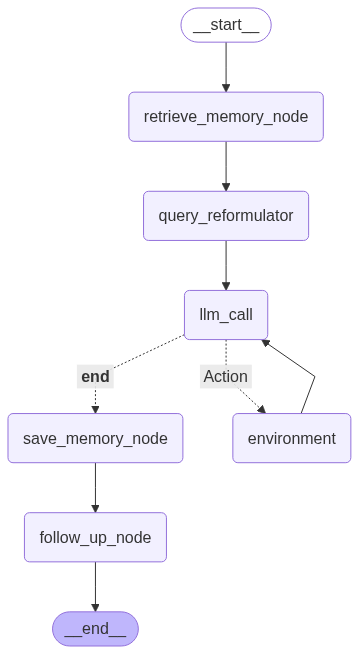

In [1112]:
from langgraph.graph import StateGraph, START
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

agent_builder = StateGraph(MessagesState)
checkpointer = InMemorySaver()
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["user_query", "reformulated_query", "final_response"]
    }
)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("retrieve_memory_node", memory_node)
agent_builder.add_node("query_reformulator", query_reformulator_node)
agent_builder.add_node("save_memory_node", save_memory_node)
agent_builder.add_node("follow_up_node", make_follow_up_node())

    # agent_builder.add_node(
# "environment",
# lambda state, config=None: {"messages": tool_node(state, config=config)["messages"]}
#     )
agent_builder.add_node("environment", tool_node)

agent_builder.add_edge(START, "retrieve_memory_node")
agent_builder.add_edge("retrieve_memory_node", "query_reformulator")
agent_builder.add_edge("query_reformulator", "llm_call")
# agent_builder.add_edge("retrieve_memory_node", "llm_call")
agent_builder.add_edge("environment", "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"Action": "environment", END: "save_memory_node"})
agent_builder.add_edge("save_memory_node", "follow_up_node")
agent_builder.add_edge("follow_up_node", END)

agent = agent_builder.compile(checkpointer=checkpointer, store=store)
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))


## Example Questions

In [1113]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage



messages = [HumanMessage(content="Claims overview for claim number F8D4EDE2?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()



📚 [Node] Retrieving memory...
📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 1 past memories
🔁 [Node] Reformulating query using structured LLM...
✅ Query is already self-contained. No reformulation needed.
📄 Loading schema and metric definitions...
🛠️ SQL Worker received query:
SELECT policy_number, claim_number, date_of_loss, claim_status, damage_description, claim_status, litigation, total_claim_bill, medical_bill, repair_bill, date_of_reporting_loss, date_of_payment_repair, date_of_payment_medical FROM fnol_data WHERE claim_number = 'F8D4EDE2';
💾 [Node] Saving memory...
💾 [Node] Follow up questions...

✅ Final Answer Confidence: 0.95
🧠 Reasoning: The information provided is detailed and aligns with the structure of claims data, including key metrics like dates, costs, and status. However, there is a slight chance of missing context or updates to the claim.
================================ Human Message =================================

Claims overview for claim number F8D4ED

In [1091]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=" Can you summarize the key details for claim number F8D4EDE2?")]
config = {"configurable": { "user_id": '1', "thread_id": '3'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()



📚 [Node] Retrieving memory...
📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 1 past memories
🔁 [Node] Reformulating query using structured LLM...
✅ Query is already self-contained. No reformulation needed.
📄 Loading schema and metric definitions...
🛠️ SQL Worker received query:
SELECT * FROM fnol_data WHERE claim_number = 'F8D4EDE2';
💾 [Node] Saving memory...
💾 [Node] Follow up questions...

✅ Final Answer Confidence: 0.95
🧠 Reasoning: The response is based on structured data and includes detailed information about the claim, such as policy details, incident specifics, evidence, medical details, and payment history. The high level of detail and alignment with the user's query indicate strong confidence in the accuracy of the summary.
================================ Human Message =================================

 Can you summarize the key details for claim number F8D4EDE2?
================================ System Message ================================

🧠 The following is past

In [438]:
# for m in result["messages"]:
#     if hasattr(m, "content") and m.type == "ai":

#         print(m.content)

In [1092]:
messages = [HumanMessage(content=" what is the claim amount for this claim ? ")]
config = {"configurable": { "user_id": '1', "thread_id": '3'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📚 [Node] Retrieving memory...
📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 2 past memories
🔁 [Node] Reformulating query using structured LLM...
🧠 Not self-contained → Reformulating based on memory
✍️ Reformulated Query: What is the claim amount for claim number F8D4EDE2?
💾 [Node] Saving memory...
💾 [Node] Follow up questions...

✅ Final Answer Confidence: 0.95
🧠 Reasoning: The claim amount details were retrieved directly from structured data, and the breakdown of medical and repair bills aligns with the claim number provided. The confidence is high because the data source is reliable and specific to the query.
================================ Human Message =================================

 Can you summarize the key details for claim number F8D4EDE2?
================================ System Message ================================

🧠 The following is past memory retrieved from previous interactions. Use it for context only. Always validate current schema, metrics, and logic as

In [1094]:
messages = [HumanMessage(content="what is the threshold value for Total loss and What is the Soft threshold damage amount for vehicles?")]
config = {"configurable": { "user_id": '1', "thread_id": '10'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📚 [Node] Retrieving memory...
📚 Retrieving recent memory for user_id: 1
🧠 Retrieved 3 past memories
🔁 [Node] Reformulating query using structured LLM...
✅ Query is already self-contained. No reformulation needed.
📥 RAG Worker received query: threshold value for Total loss
📥 RAG Worker received query: Soft threshold damage amount for vehicles
💾 [Node] Saving memory...
💾 [Node] Follow up questions...

✅ Final Answer Confidence: 0.90
🧠 Reasoning: The answer is based on specific thresholds and guidelines retrieved from claims management workflows and Mitchell evaluation criteria. These are standard industry practices, and the information aligns with the user's query. However, the confidence is not 100% because the context may vary slightly depending on jurisdiction or specific policy terms.
================================ Human Message =================================

what is the threshold value for Total loss and What is the Soft threshold damage amount for vehicles?
==================

In [659]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="what are the conditions for classifying a claim as a complex BI claim ?")]
config = {"configurable": { "user_id": '1', "thread_id": '3'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

📥 RAG Worker received query: Conditions for classifying a claim as a complex BI claim
================================ Human Message =================================

what is the threshold value for Total loss and What is the Soft threshold damage amount for vehicles?
================================== Ai Message ==================================
Tool Calls:
  rag_worker_tool (call_6q9pgMSu1vfAelgk81Jah1t8)
 Call ID: call_6q9pgMSu1vfAelgk81Jah1t8
  Args:
    query: Threshold value for Total loss and Soft threshold damage amount for vehicles
================================= Tool Message =================================

to completion, unless it’s been escalated to a Field Appraiser Escalation Triggers Escalations: Vehicle Type and General Triggers Large commercial, specialty or most non-drivable vehicles Exotic vehicles Drivable vehicles 25 years or older Customer (insured) requests a field inspection Certain loss states that restrict remote estimating Coverage/Liability Triggers Fu

In [393]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="for claim number C9CB6205 , should it classify this as complex BI claim ?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

🛠️ SQL Worker received query:
SELECT * FROM claims WHERE claim_number = 'C9CB6205';
📄 Loading schema and metric definitions...
🛠️ SQL Worker received query:
SELECT * FROM fnol_data WHERE claim_number = 'C9CB6205';
🧠 Synthesizing final output...
💾 Saving memory...
✅ Memory saved.
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  retrieve_recent_memory (call_4TTptnzcYllsCAD9vIWvKpnQ)
 Call ID: call_4TTptnzcYllsCAD9vIWvKpnQ
  Args:
    user_query: What's the state with the most litigation claims?
================================= Tool Message =================================

(no relevant memory found)
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_N4vTKaAHyHsaXVHR2bZfYCZH)
 Call ID: call_N4vTKaAHyHsaXVHR2bZfYCZH
  Args:
=======================

In [342]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="what is the average claim amount for claims with subrogation opportunity?")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

🛠️ SQL Worker received query:
SELECT AVG(total_claim_bill) as average_claim_amount FROM fnol_data WHERE subro_opportunity = 1;
💾 Saving memory...
✅ Memory saved.
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  retrieve_recent_memory (call_Cf2PeMICykzmrzZxzHAThMjL)
 Call ID: call_Cf2PeMICykzmrzZxzHAThMjL
  Args:
    user_query: What's the state with the most litigation claims?
================================= Tool Message =================================

(no relevant memory found)
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_EdF4x6bL60dk6T6r3QsMYJBX)
 Call ID: call_EdF4x6bL60dk6T6r3QsMYJBX
  Args:
================================= Tool Message =================================

=== TABLE SCHEMA ===
{
  "fnol_data": {
    "claim_number":

In [ ]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="how does the avg amount vary by medical injuries ? Suggest follow ups")]
config = {"configurable": { "user_id": '1', "thread_id": '2'}}
result = agent.invoke({"messages": messages},config=config)

for m in result["messages"]:
    m.pretty_print()

🧐 Checking query clarity and possibly reformulating...
🔍 Reformulation required: True
✍️ Reformulated Query: What is the average claim amount for each level of medical injury severity, including high, medium, low, and N/A severity?
================================ Human Message =================================

 What's the state with the most litigation claims?
================================== Ai Message ==================================
Tool Calls:
  retrieve_recent_memory (call_Cf2PeMICykzmrzZxzHAThMjL)
 Call ID: call_Cf2PeMICykzmrzZxzHAThMjL
  Args:
    user_query: What's the state with the most litigation claims?
================================= Tool Message =================================

(no relevant memory found)
================================== Ai Message ==================================
Tool Calls:
  get_schema_tool (call_EdF4x6bL60dk6T6r3QsMYJBX)
 Call ID: call_EdF4x6bL60dk6T6r3QsMYJBX
  Args:
================================= Tool Message ========================